In [10]:
]activate .

  Activating environment at `~/projects/gambit/notebooks/labnb/experiments/211011-gambit-ani-additional-genomes/Project.toml`


In [11]:
using ProgressMeter
using FilePathsBase; using FilePathsBase: /
using NCDatasets
# using GZip
# using JSON
# using Mmap
using DataFrames
using CSV
# using StatsBase
# using CategoricalArrays
# using HDF5
# using Markdown
# using DataStructures: counter
using AbstractTrees
using Clustering

using PlotlyJS
using Colors
using ColorSchemes

WebIO._IJuliaInit()

In [12]:
using ClusterAnalysis

In [13]:
using MidasPlots
using MidasPlots.Plotly

## Setup

In [14]:
ENV["COLUMNS"] = 200

200

In [15]:
infiles = Dict(
    :genomes => p"data-processed/211015-combine-data/211015-gambit-ani-genomes.csv",
    :genome_taxids => p"data-intermediate/211019-get-taxonomy-tree/genome-taxids.csv",
    :taxa => p"data-intermediate/211019-get-taxonomy-tree/taxa.csv",
    :data => p"data-intermediate/211015-combine-data/data.nc",
);

## Load data

In [16]:
genomes = DataFrame(CSV.File(infiles[:genomes]));

In [17]:
gsets = string.(unique(genomes[!, :data_set]))

4-element Vector{String}:
 "konstantinidis_2005"
 "snitkin_2012"
 "ondov_2016"
 "200726_gold_standard"

In [18]:
let
    taxid_df = DataFrame(CSV.File(infiles[:genome_taxids]))
    @assert taxid_df[!, [:data_set, :ds_index]] == genomes[!, [:data_set, :ds_index]]
    genomes[!, :taxid] = taxid_df[!, :taxid]
end;

In [19]:
taxa_df = DataFrame(CSV.File(infiles[:taxa]));

In [20]:
root_ds = Dataset(string(infiles[:data]))

common_ds = root_ds.group["common"]
genome_dss = Dict(gset => root_ds.group["genome"].group[gset] for gset in gsets);

## Taxonomy tree

### Defs

In [126]:
function find_lca(nodes)
    it = iterate(nodes)
    isnothing(it) && return nothing
    t, state = it
    trunk = collect(ancestors(t, incself=true))

    for t in Iterators.rest(nodes, state)
        found = false
        
        for a in ancestors(t, incself=true)
            i = findfirst(isequal(a), trunk)
            
            if !isnothing(i)
                trunk = @view trunk[i:end]
                found = true
                break
            end
        end
        
        found || return nothing
    end
    
    return first(trunk)
end

find_lca (generic function with 1 method)

In [226]:
function genomes_pw_to_matrix(ds::NCDataset, values::AbstractVector)
    ng = ds.dim["genome"]
    g1 = ds["g1"] .+ 1
    g2 = ds["g2"] .+ 1
    
    pair_idxs_lower = CartesianIndex.(zip(g1, g2))
    pair_idxs_upper = CartesianIndex.(zip(g2, g1))
    
    T = nonmissingtype(eltype(values))
    mat = Matrix{T}(undef, ng, ng);
    mat[pair_idxs_lower] = values
    mat[pair_idxs_upper] = values
    
    return mat
end

genomes_pw_to_matrix (generic function with 2 methods)

In [83]:
function ClusterAnalysis.nodeattrs!(ta::TreeAnnotations, col::Symbol, id::Integer, value)
    ta.node_attrs[ta.node_lookup[id], col] = value
end

### Assemble

In [2]:
using Revise

In [43]:
using AbstractTreesDev.ParentAPI
using AbstractTreesDev.IDTrees: IDTree, IDNode, addnode!, finalize!

In [44]:
TaxonData = @NamedTuple{name::String, rank::String};
AbstractTrees.printnode(io::IO, node::IDNode{<:Any, TaxonData}) = print(io, "[$(node.id)] $(node.val.name) ($(node.val.rank))")

In [24]:
taxa = IDTree{Int}(TaxonData);

for row in eachrow(taxa_df)
    addnode!(taxa, row.taxid, coalesce(row.parent, nothing), TaxonData((row.name, row.rank)))
end

finalize!(taxa)

In [222]:
nonmissingtype

nonmissingtype (generic function with 1 method)

## Konstantinidis

In [77]:
gset = "konstantinidis_2005"
ds = genome_dss[gset];

In [78]:
ng = ds.dim["genome"]

70

In [79]:
gset_genomes = genomes[genomes.data_set .== gset, :]
@assert issorted(gset_genomes.ds_index)

### Cluster

In [228]:
dmat = genomes_pw_to_matrix(ds, ds["dist"][:, 73]);

In [229]:
tree = ClusterAnalysis.hclust(dmat, linkage=:average);

In [230]:
ta = TreeAnnotations(tree, :dmat => ani_dist)

ta.node_attrs[!, :lca] .= 0;

In [231]:
hc_nodeid(i::Integer) = i
hc_nodeid(n::ClusterAnalysis.HClustNode) = n.id

hc_nodeid (generic function with 2 methods)

In [232]:
for node in PostOrderDFS(tree.root)
    id = hc_nodeid(node)
    cids = map(hc_nodeid, children(node))
    
    lca = if isempty(cids)
        gset_genomes[id, :taxid]
    else
        child_lcas = nodeattrs(ta, cids, :lca)
        lca_tax = find_lca(taxa[id] for id in child_lcas)
        @assert !isnothing(lca_tax) child_lcas
        lca_tax.id
    end
        
    nodeattrs!(ta, :lca, id, lca)
end

### Dendrogram

In [233]:
dg = Dendrogram(tree)

Dendrogram with 139 nodes and 70 leaves

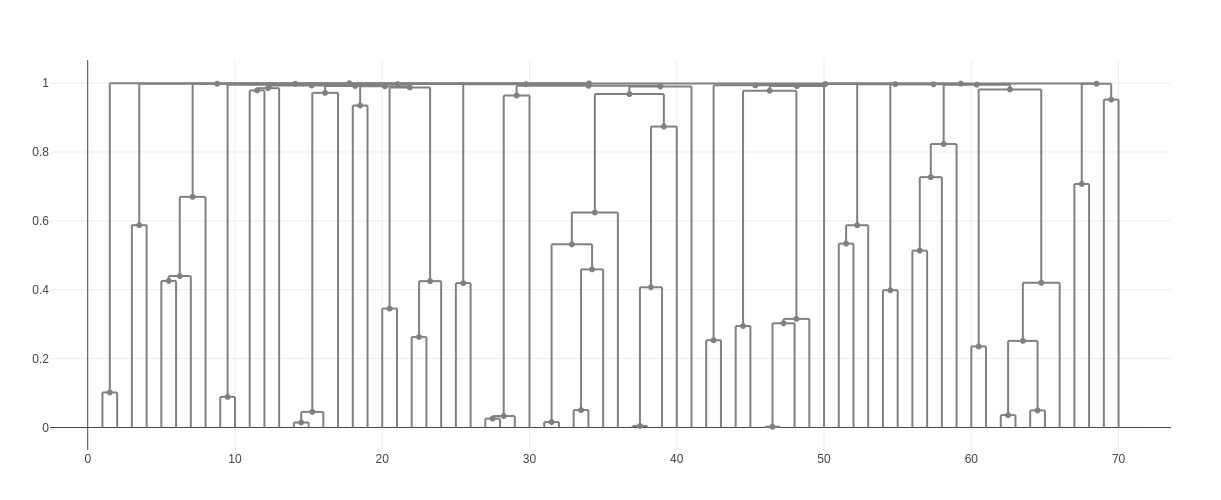

In [234]:
pdg = PlotlyDendrogram(dg)

vector_attrs!(pdg.nodes_trace, pdg.node_ids) do id
    row = nodeattrs(ta, id)
    taxon = taxa[row.lca]
    Dict(
        :text => taxon.val.name
    )
end

pdg.nodes_trace[:hovertemplate] = "%{text}<br>%{y}<extra></extra>"

plot(pdg)